In [1]:
from koh import *
import pandas as pd
import numpy as np
import struct
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import copy
from sklearn.manifold import TSNE


In [2]:
def visualise_kohonen(closest_data, closest_data2):
    h = closest_data.shape[0]
    w = closest_data.shape[1]
    category_colors = [
        "#e41a1c",  # Red
        "#377eb8",  # Blue
        "#4daf4a",  # Green
        "#984ea3",  # Purple
        "#ff7f00",  # Orange
        "#ffff33",  # Yellow
        "#a65628",  # Brown
        "#f781bf",  # Pink
        "#999999",  # Gray
        "#66c2a5",  # Turquoise
        "#fc8d62",  # Salmon
        "#8da0cb",  # Lavender
        "#e78ac3",  # Light pink
        "#a6d854",  # Lime green
        "#ffd92f",  # Bright yellow
        "#e5c494",  # Beige
        "#b3b3b3",  # Light gray
        "#1f78b4",  # Steel blue
        "#33a02c",  # Dark green
        "#fb9a99",  # Light red
    ]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.set_aspect('equal')
    ax.axis('off')

    max_circles_per_row = 5
    circle_radius = 0.07
    for x in range(20):
        for y in range(20):
            counts = closest_data[y, x]
            majority_color = category_colors[closest_data2[y, x]]

            # Draw the neuron square
            neuron = Rectangle((x, h - 1 - y), 1, 1, color=majority_color, ec='black', lw=0.5, alpha=1)
            ax.add_patch(neuron)
            total = counts.sum()
            if total == 0:
                continue  # Nothing to draw


            tot_count = 0
            for cat_idx, count in enumerate(counts):
                for n in range(count):
                    # Layout: rows of max_circles_per_row
                    row = tot_count // max_circles_per_row
                    col = tot_count % max_circles_per_row

                    spacing = 1 / max_circles_per_row
                    cx = x + 0.10 + col * spacing
                    cy = h - 1 - y + 0.85 - row * spacing

                    if cy < h - 1 - y:  # Stay inside the square
                        break

                    circ = Circle(
                        (cx, cy),
                        radius=circle_radius,
                        color=category_colors[cat_idx],
                        ec='black',
                        lw=0.25
                    )
                    ax.add_patch(circ)
                    tot_count += 1

    plt.tight_layout()
    plt.show()

def get_closest_data(weights, labeled):
    #we assume categories are coded starting from 0
    n_cat = int(np.max(labeled[:,-1])) + 1
    h, w, d = weights.shape
    closest_data = np.zeros((h, w, n_cat), dtype=int)
    dims = labeled.shape[1] - 1
    for labeled_row in labeled:
        coords = labeled_row[:dims]
        cat = int(labeled_row[dims])
        #get closest nauron coords
        min_dist = float('inf')
        min_coords = (0,0)
        for i in range(h):
            for j in range(w):
                if np.sum((coords - weights[i][j])**2) < min_dist:
                    min_dist = np.sum((coords - weights[i][j])**2)
                    min_coords = (i, j)
        x, y = min_coords

        closest_data[x,y,cat] += 1
    return closest_data

def get_closest_data_neuron(weights, labeled):
    h, w, d = weights.shape
    closest_data = np.zeros((h, w), dtype=int)
    dims = labeled.shape[1] - 1
    for i in range(h):
        for j in range(w):
            neuron = weights[i][j]
            min_dist = float('inf')
            min_cat = 0
            for labelled_row in labeled:
                coords = labelled_row[:dims]
                if np.sum((coords - weights[i][j])**2) < min_dist:
                    min_dist = np.sum((coords - weights[i][j])**2)
                    min_cat = int(labelled_row[dims])
            closest_data[i,j] = min_cat
    return closest_data


In [3]:
def reshape_from_abcsq_to_acbc(array):
    a,b,c = array.shape
    c = int(np.sqrt(c))
    array = array.reshape(a, b, c, c)
    array = array.transpose(0, 2, 1, 3)
    array = array.reshape(a *c, a * c)
    return array


In [4]:
def load_idx3_ubyte(file_path):
    with open(file_path, 'rb') as f:
        magic_number, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num_images, rows, cols))
    return data

def load_idx1_ubyte(file_path):
    with open(file_path, 'rb') as f:
        magic_number, num_labels = struct.unpack('>II', f.read(8))  # Read 8 bytes: magic number and number of labels
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Read the rest as unsigned bytes
    return labels


# 1.1 MNIST prostokątna gauss

In [5]:

images = load_idx3_ubyte('data/MNIST/train-images.idx3-ubyte')
images_1D = images.reshape(-1, 784)
labels = load_idx1_ubyte('data/MNIST/train-labels.idx1-ubyte')


100%|██████████| 10000/10000 [00:31<00:00, 314.87it/s]


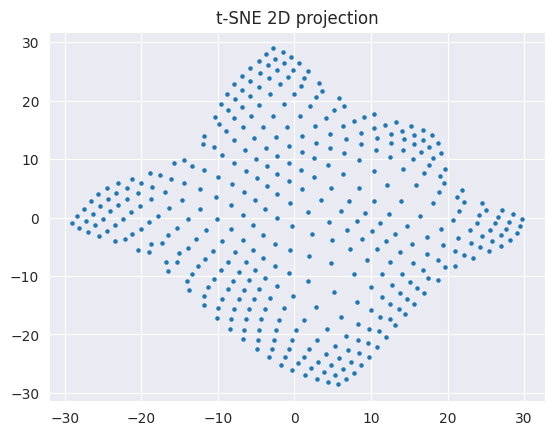

In [32]:
network = KohonenNetwork(20,20)
network.set_sigma(10)
network.set_neighborhood('gaussian')
network.set_lambda(250000)
network.learn(images_1D, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 784)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(weights)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
plt.title('t-SNE 2D projection')
plt.show()




# Mapowanie z 784 do 2 wymiarów nie daje jak widać oszałamiających rezultatów

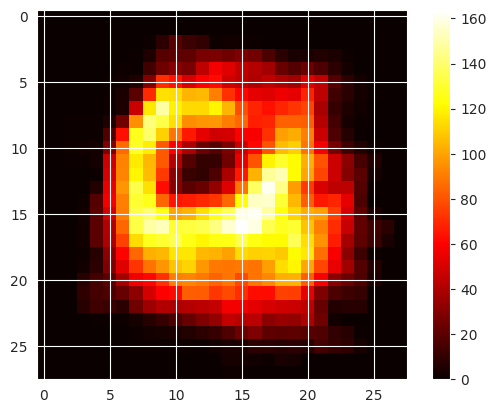

In [33]:
plt.imshow(weights[350].reshape(-1, 28), cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()

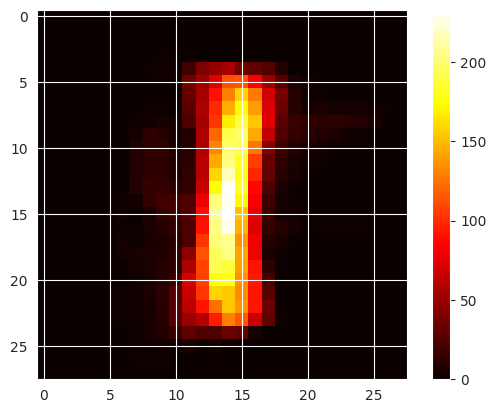

In [34]:

plt.imshow(weights[0].reshape(-1, 28), cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()


# Neurony jednak ewidentnie czegoś się nauczyły

 # 0 - Red
 # 1 - Blue
 # 2 - Green
 # 3 - Purple
 # 4 - Orange
 # 5 - Yellow
 # 6 - Brown
 # 7 - Pink
 # 8 - Gray
 # 9 - Turquoise

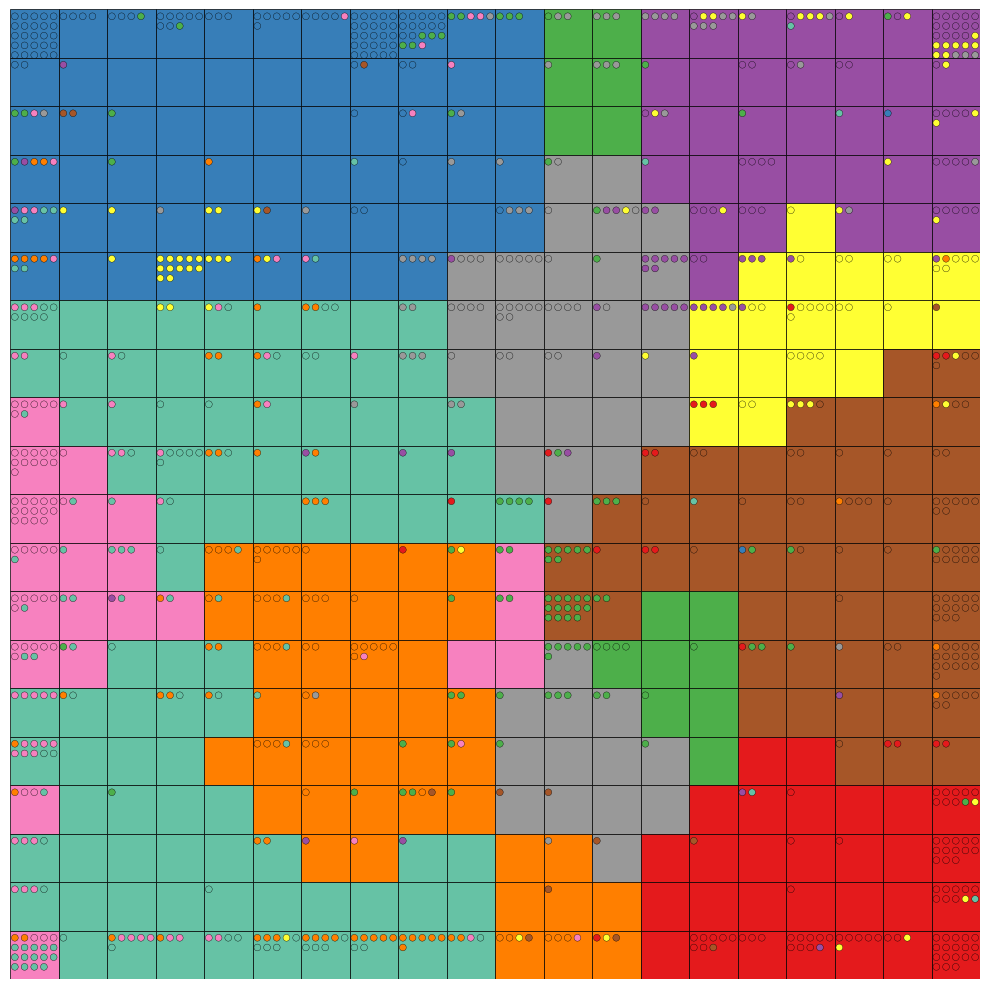

In [35]:
labeled  = np.hstack((images_1D, labels.reshape(-1, 1)))
weightsnp = copy.deepcopy(network.weights)
for i in range(len(weightsnp)):
    for j in range(len(weightsnp[0])):
        weightsnp[i][j] = list(weightsnp[i][j])

weightsnp = np.array(weightsnp)
closest_data = get_closest_data(weightsnp, labeled[:1000])
closest_data2 = get_closest_data_neuron(weightsnp, labeled[:1000])
visualise_kohonen(closest_data, closest_data2)

In [83]:
weights = np.array(network.weights)
matrix_of_matrices = reshape_from_abcsq_to_acbc(weights)

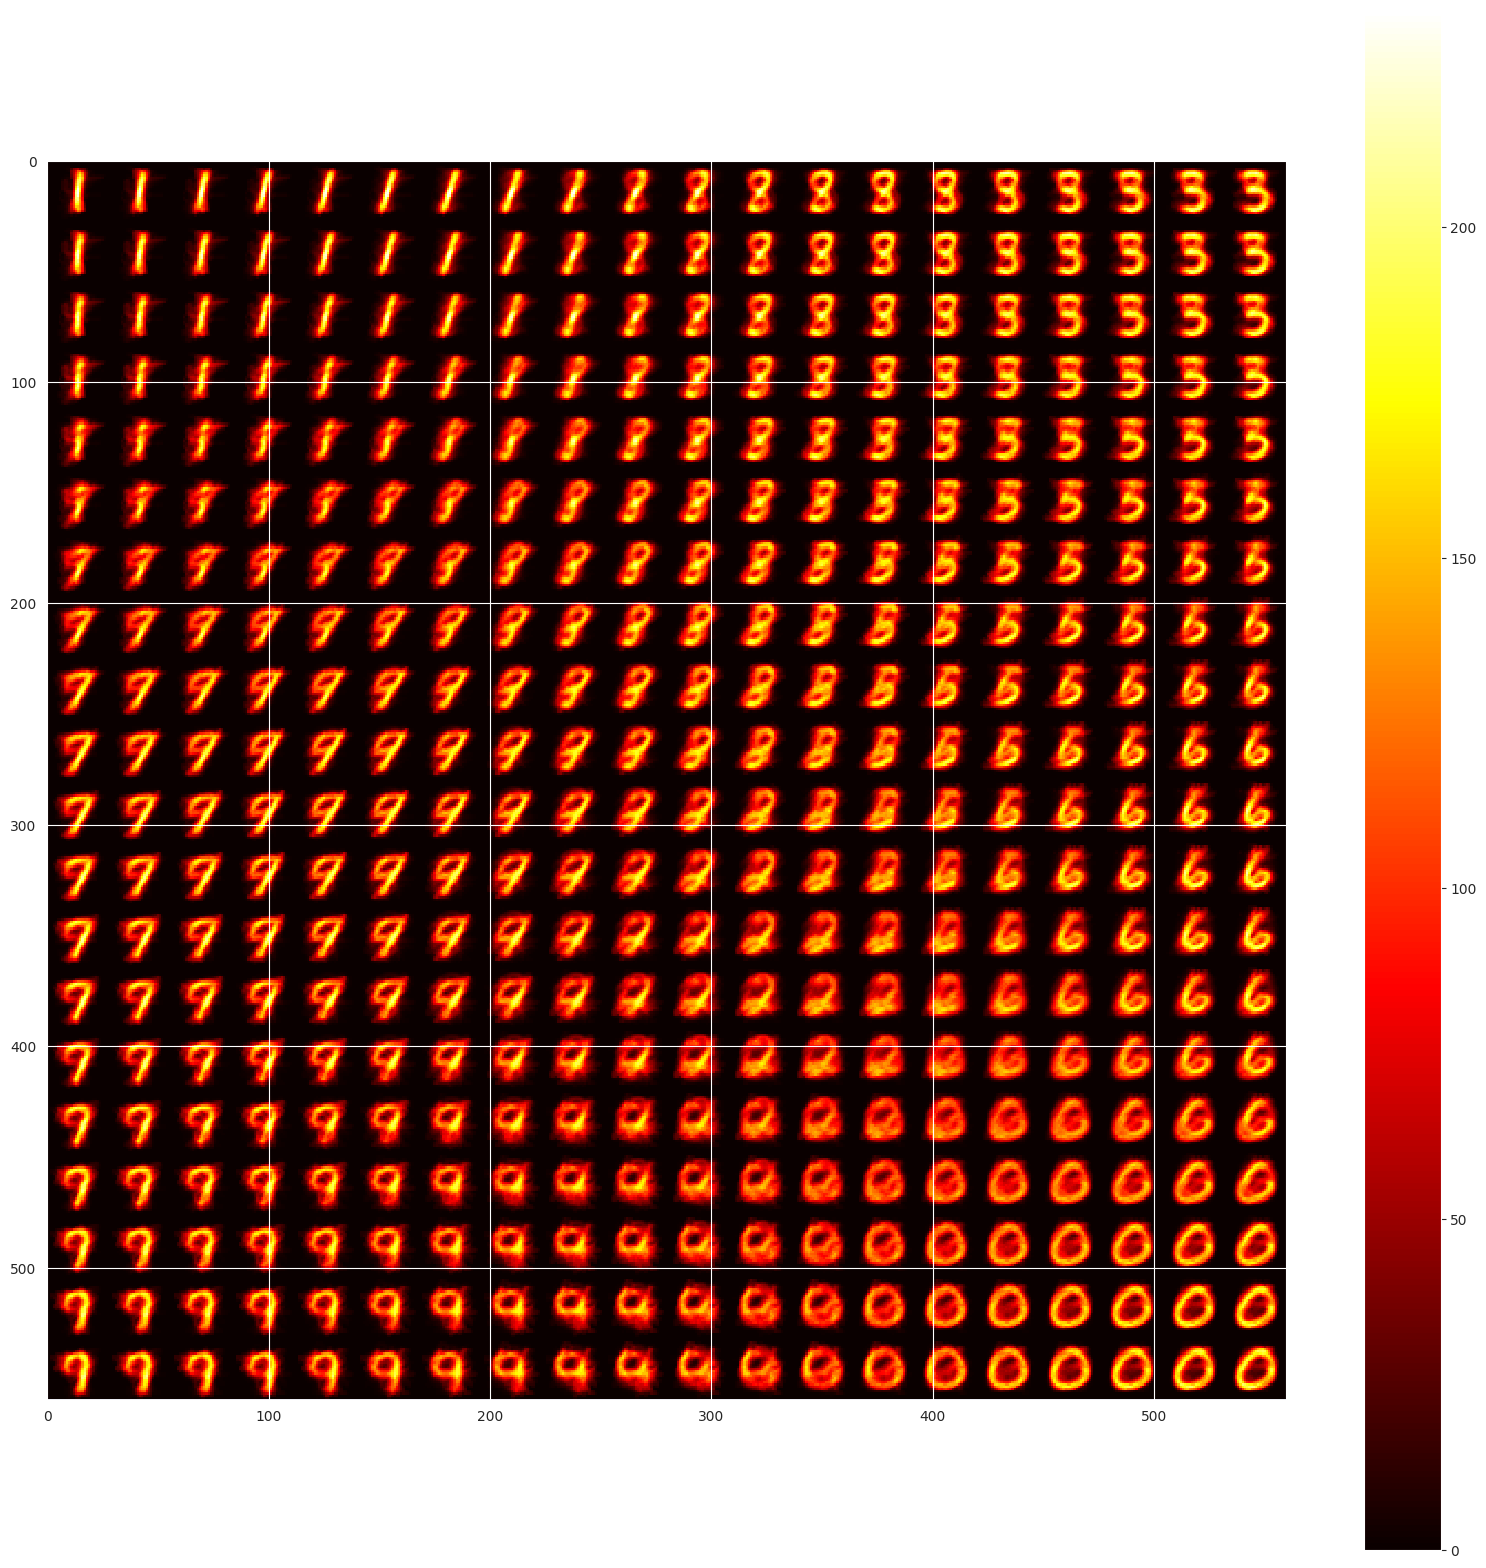

In [84]:
plt.figure(figsize=(20,20))
plt.imshow(matrix_of_matrices, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()

# 1.2 MNIST prostokątna kapelusz (jest zawsze podejrzany)

100%|██████████| 10000/10000 [00:34<00:00, 291.60it/s]


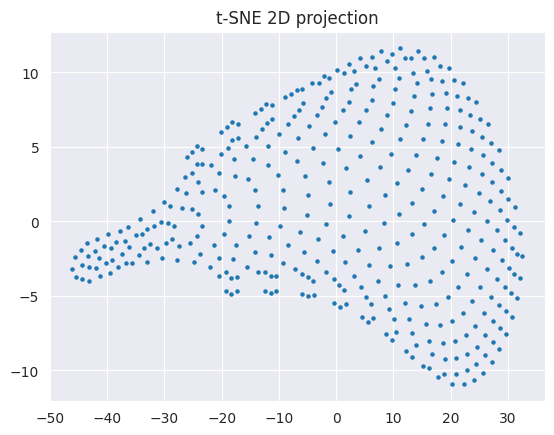

In [105]:
network = KohonenNetwork(20,20)
network.set_sigma(250)
network.set_neighborhood('sec_gaussian_der')
network.set_lambda(250000)
network.learn(images_1D, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 784)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(weights)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
plt.title('t-SNE 2D projection')
plt.show()

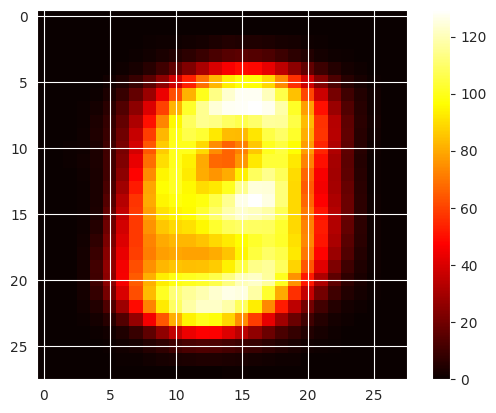

In [106]:
plt.imshow(weights[350].reshape(-1, 28), cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()

 # 0 - Red
 # 1 - Blue
 # 2 - Green
 # 3 - Purple
 # 4 - Orange
 # 5 - Yellow
 # 6 - Brown
 # 7 - Pink
 # 8 - Gray
 # 9 - Turquoise

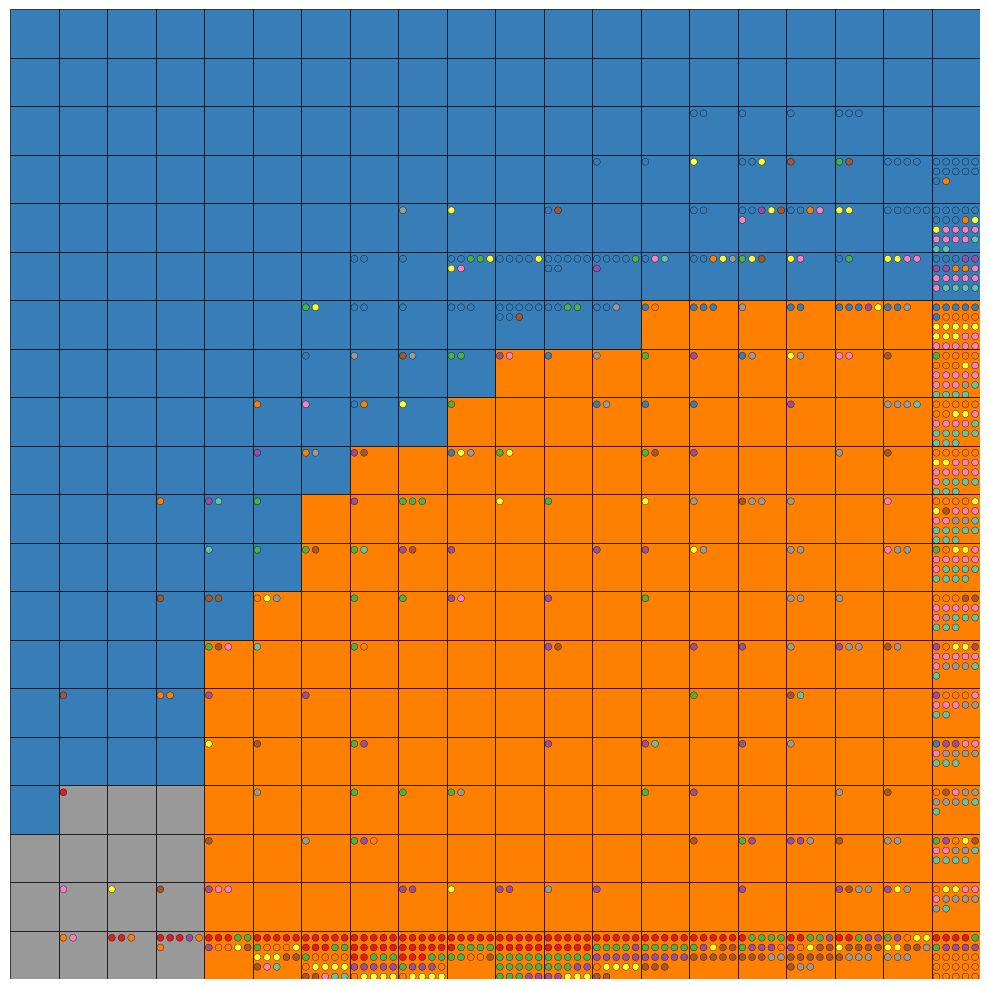

In [107]:
labeled  = np.hstack((images_1D, labels.reshape(-1, 1)))
weightsnp = copy.deepcopy(network.weights)
for i in range(len(weightsnp)):
    for j in range(len(weightsnp[0])):
        weightsnp[i][j] = list(weightsnp[i][j])

weightsnp = np.array(weightsnp)
closest_data = get_closest_data(weightsnp, labeled[:1000])
closest_data2 = get_closest_data_neuron(weightsnp, labeled[:1000])
visualise_kohonen(closest_data, closest_data2)

In [103]:
weights = np.array(network.weights)
matrix_of_matrices = reshape_from_abcsq_to_acbc(weights)

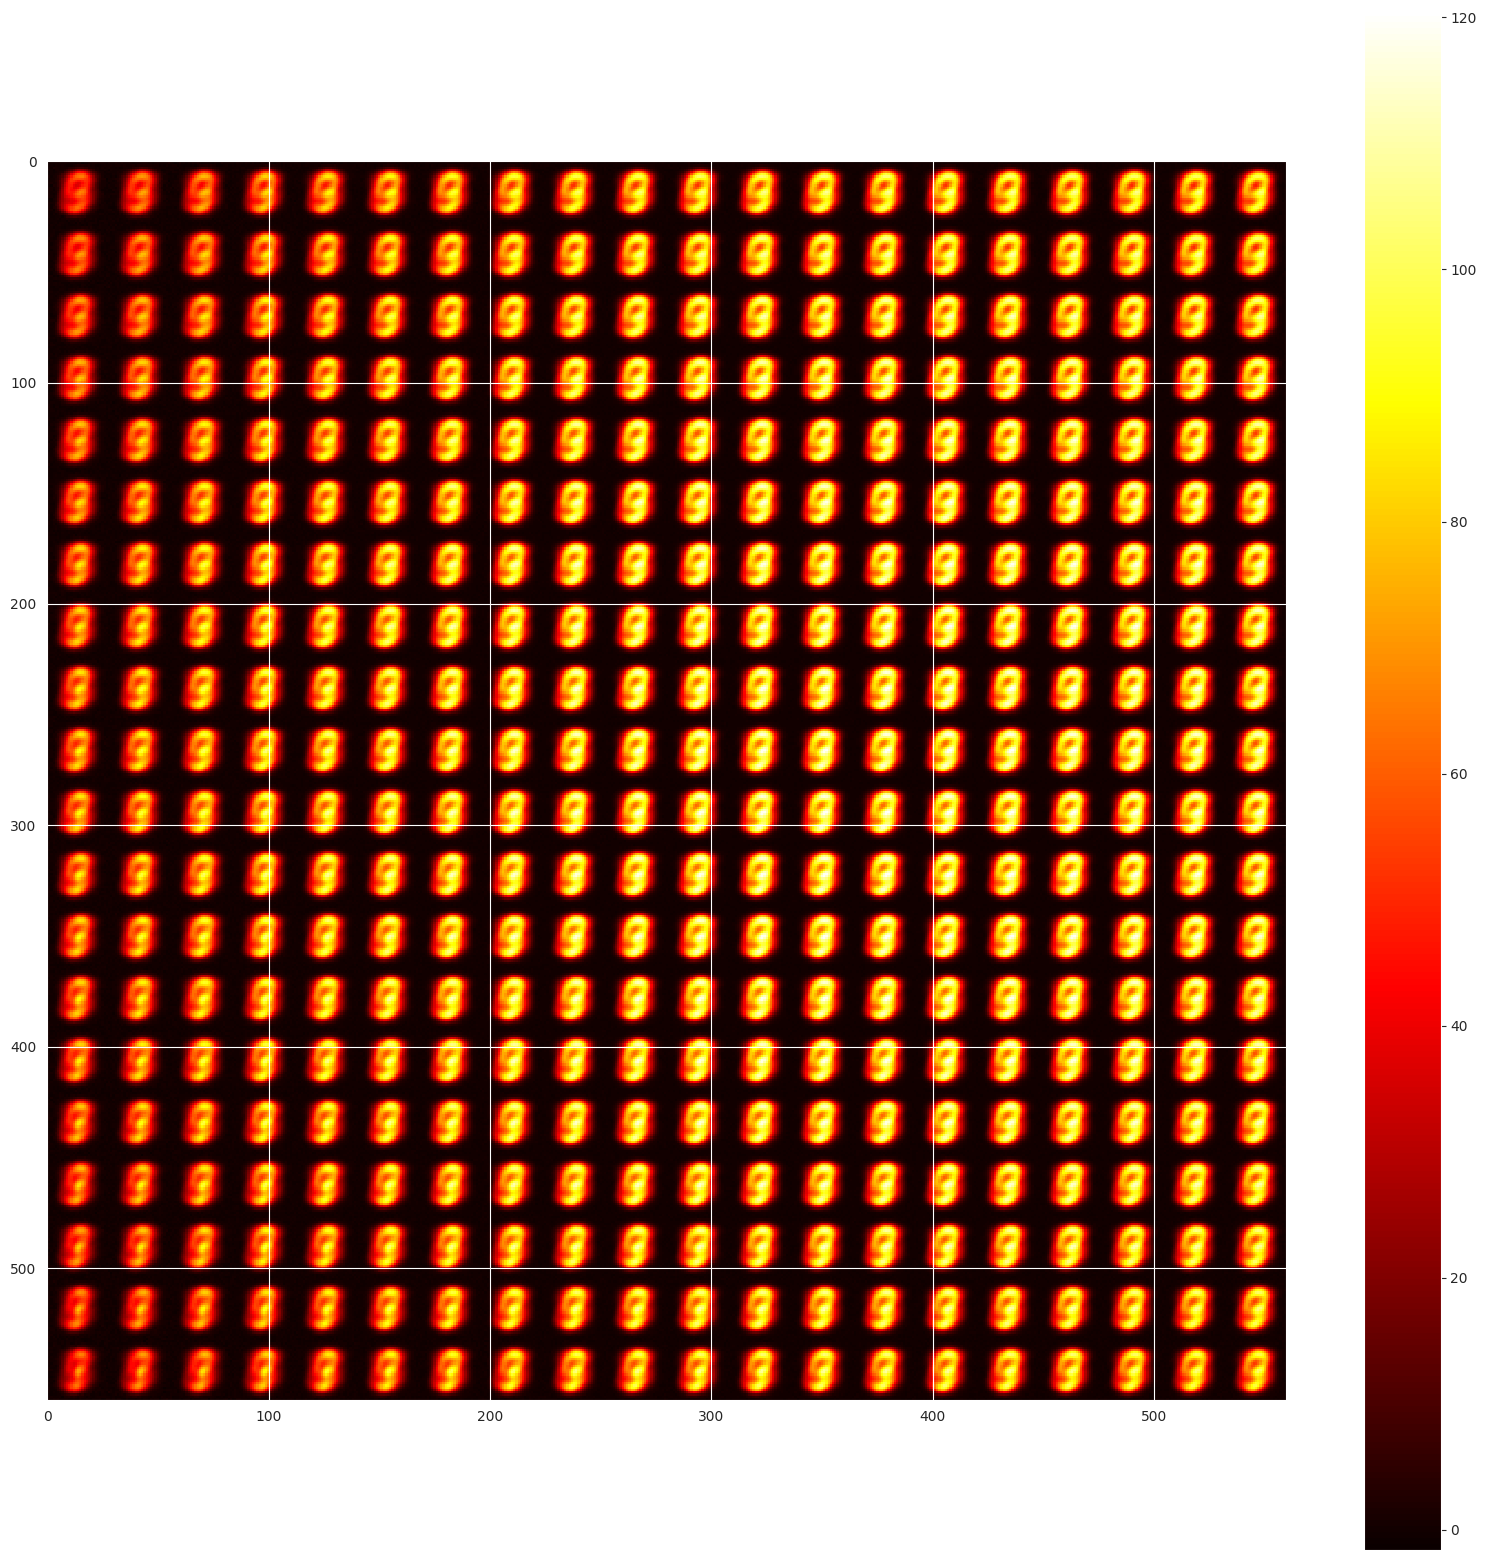

In [104]:
plt.figure(figsize=(20,20))
plt.imshow(matrix_of_matrices, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()

# 1.3 MNIST sześciokątna gauss

100%|██████████| 10000/10000 [00:52<00:00, 188.96it/s]


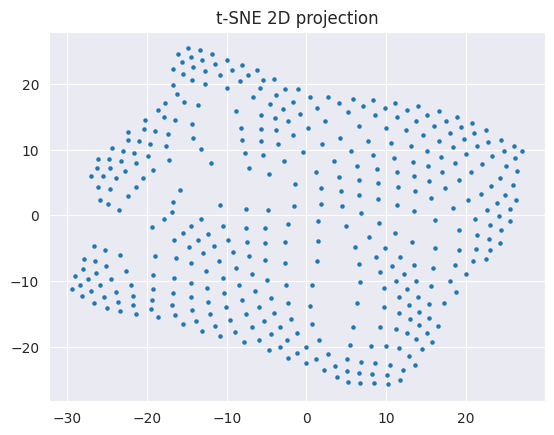

In [6]:
network = KohonenNetwork(20,20, True)
network.set_sigma(10)
network.set_neighborhood('gaussian')
network.set_lambda(250000)
network.learn(images_1D, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 784)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(weights)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
plt.title('t-SNE 2D projection')
plt.show()

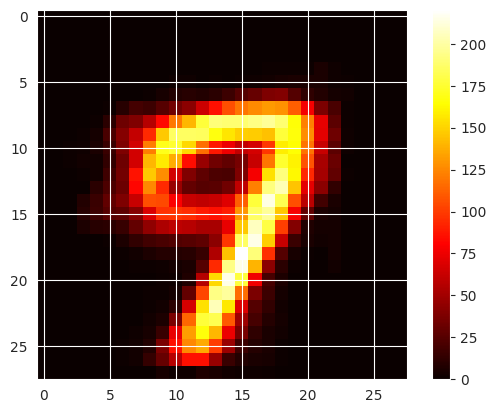

In [7]:
plt.imshow(weights[350].reshape(-1, 28), cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()

# 0 - Red
# 1 - Blue
# 2 - Green
# 3 - Purple
# 4 - Orange
# 5 - Yellow
# 6 - Brown
# 7 - Pink
# 8 - Gray
# 9 - Turquoise

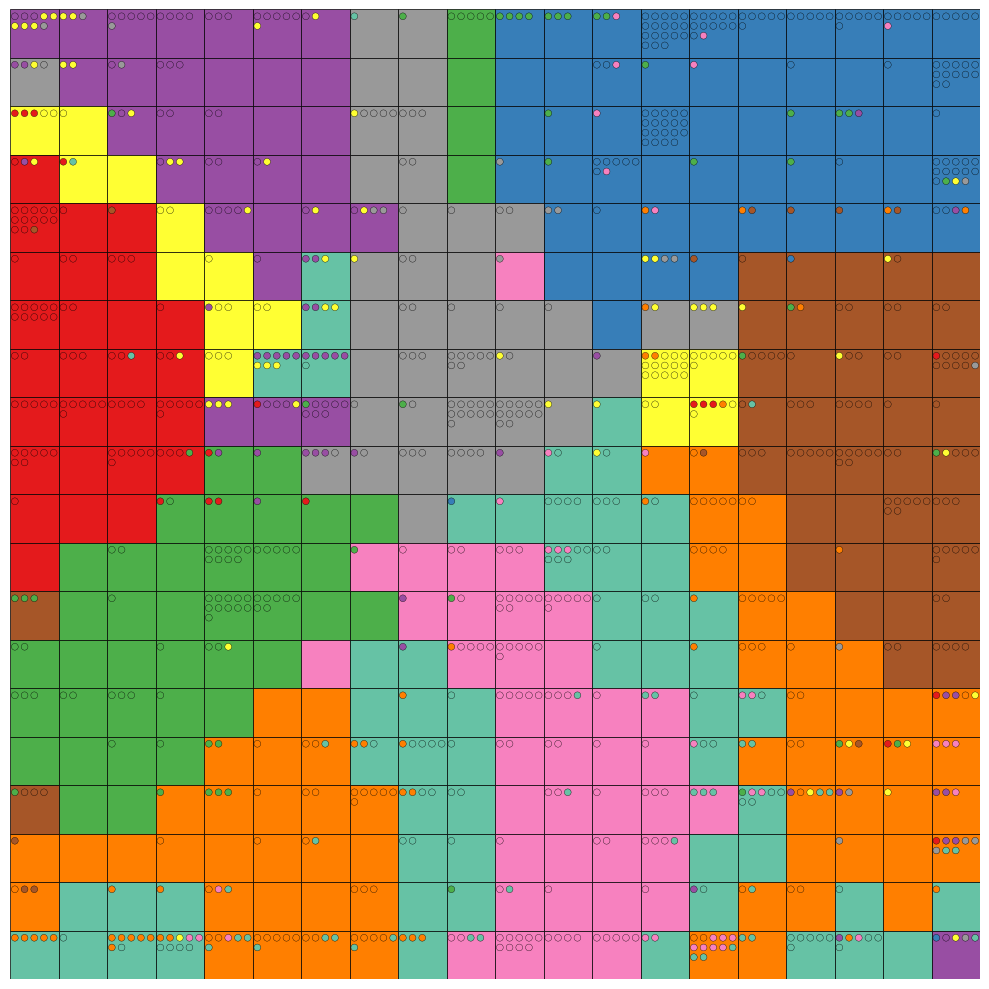

In [8]:
labeled = np.hstack((images_1D, labels.reshape(-1, 1)))
weightsnp = copy.deepcopy(network.weights)
for i in range(len(weightsnp)):
    for j in range(len(weightsnp[0])):
        weightsnp[i][j] = list(weightsnp[i][j])

weightsnp = np.array(weightsnp)
closest_data = get_closest_data(weightsnp, labeled[:1000])
closest_data2 = get_closest_data_neuron(weightsnp, labeled[:1000])
visualise_kohonen(closest_data, closest_data2)

In [9]:
weights = np.array(network.weights)
matrix_of_matrices = reshape_from_abcsq_to_acbc(weights)

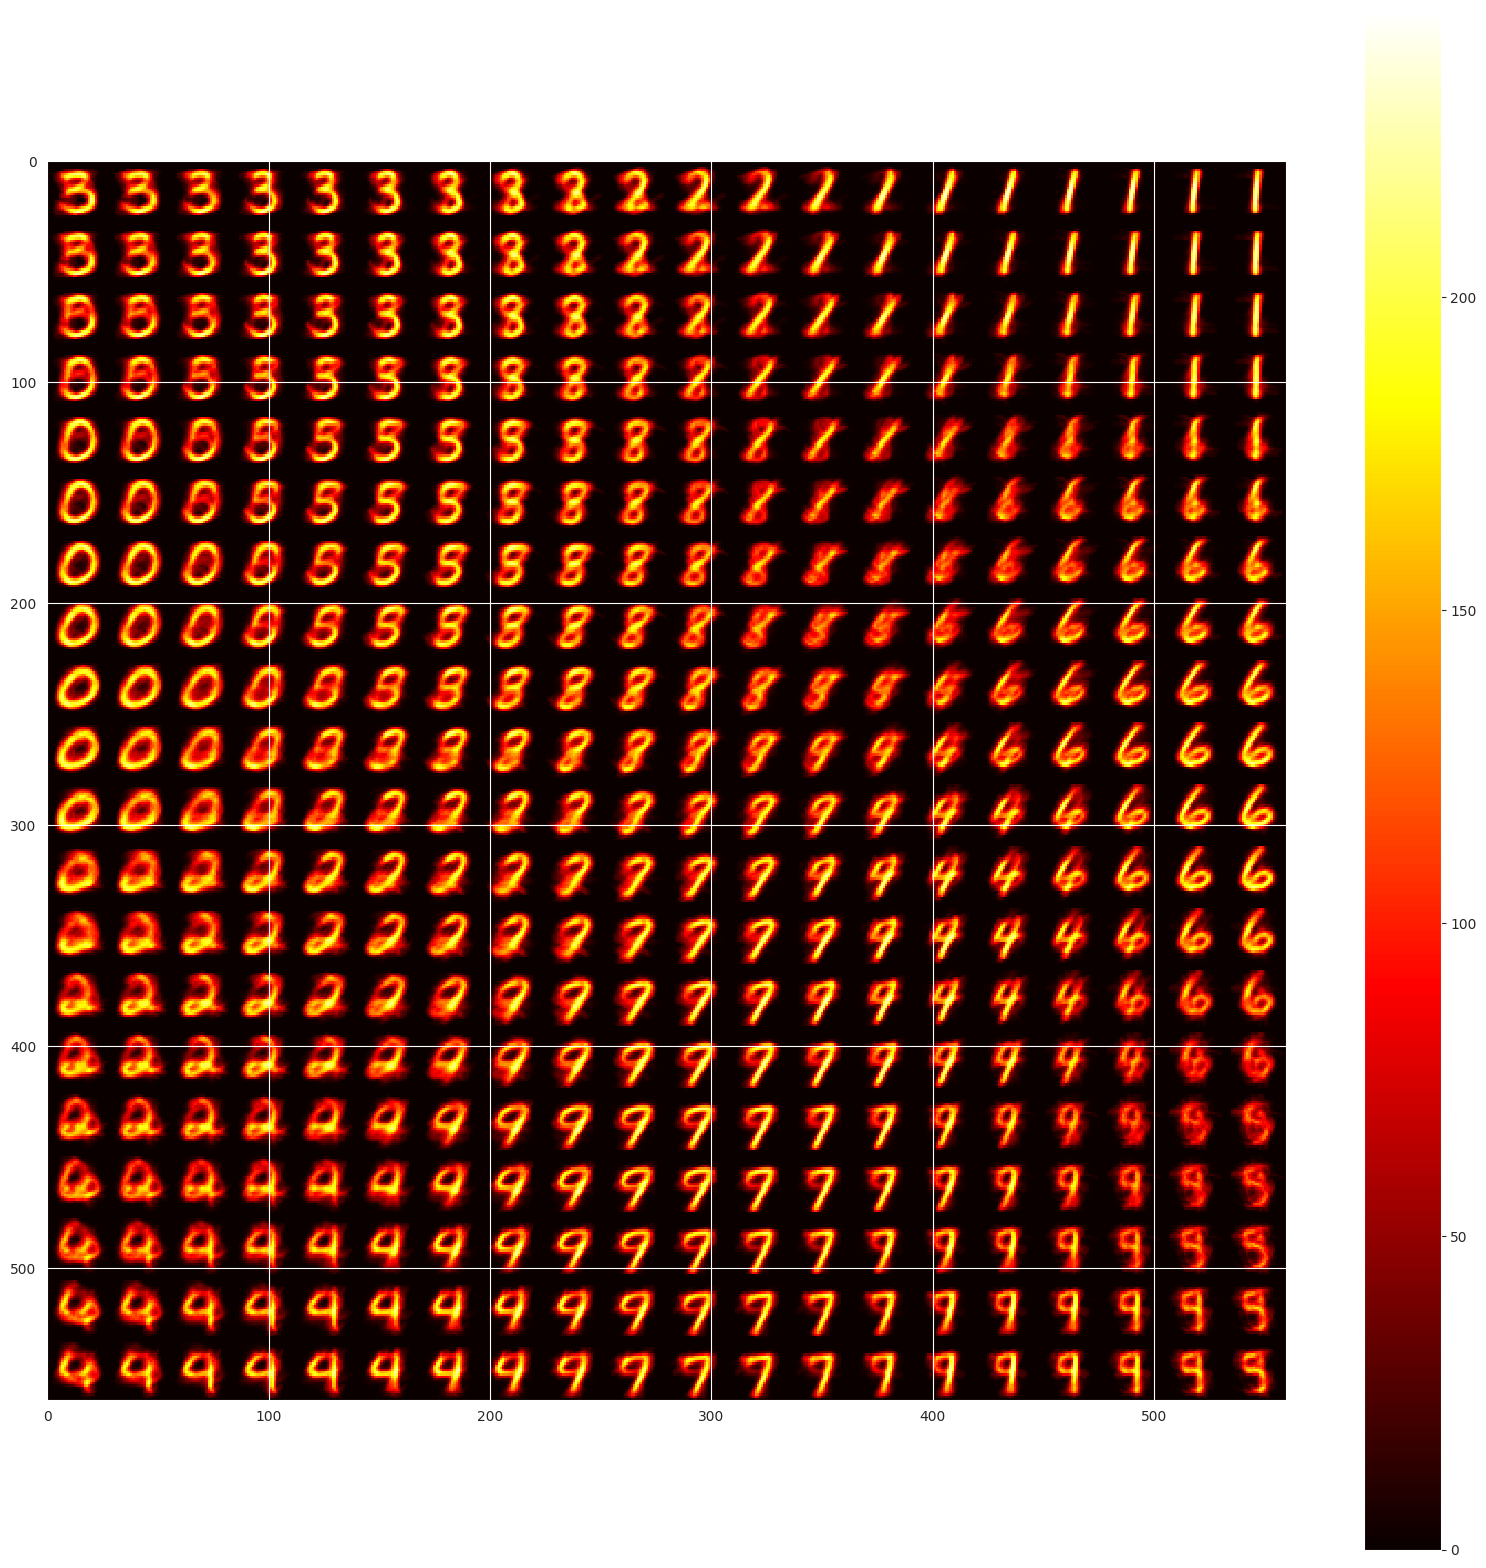

In [10]:
plt.figure(figsize=(20,20))
plt.imshow(matrix_of_matrices, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar on the side
plt.show()

In [18]:
X = np.loadtxt('data/activity_recognition/UCI_HAR_Dataset/UCI_HAR_Dataset/train/X_train.txt')
y = np.loadtxt('data/activity_recognition/UCI_HAR_Dataset/UCI_HAR_Dataset/train/y_train.txt')


100%|██████████| 10000/10000 [00:29<00:00, 342.89it/s]


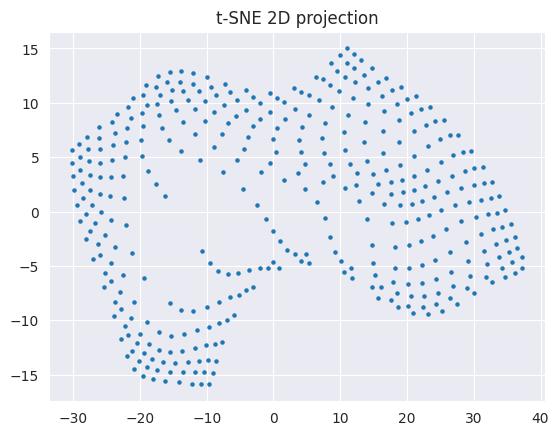

In [20]:
network = KohonenNetwork(20,20)
network.set_sigma(10)
network.set_neighborhood('gaussian')
network.set_lambda(250000)
network.learn(X, 10000)

weights = network.weights
weights = np.array(weights)
weights = weights.reshape(-1, 561)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(weights)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
plt.title('t-SNE 2D projection')
plt.show()


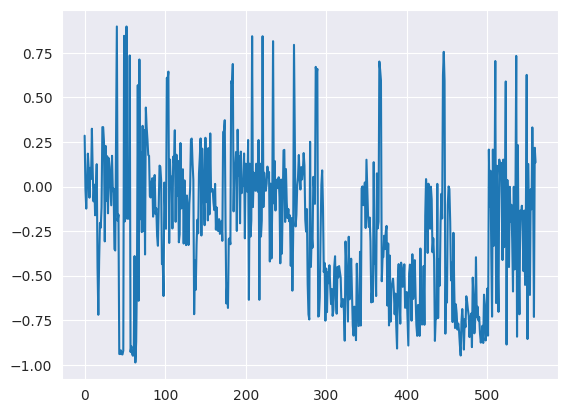

In [22]:
plt.plot(weights[0])

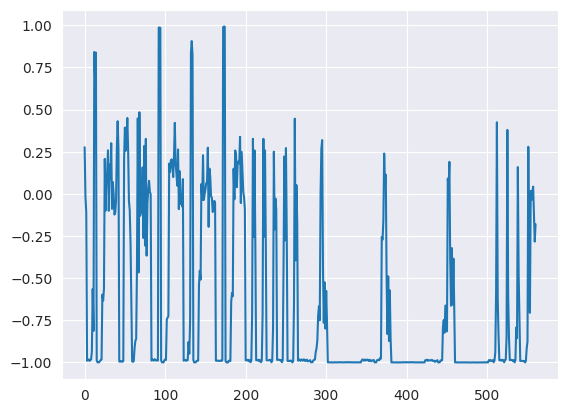

In [24]:
plt.plot(weights[350])

# 0 - Red
# 1 - Blue
# 2 - Green
# 3 - Purple
# 4 - Orange
# 5 - Yellow

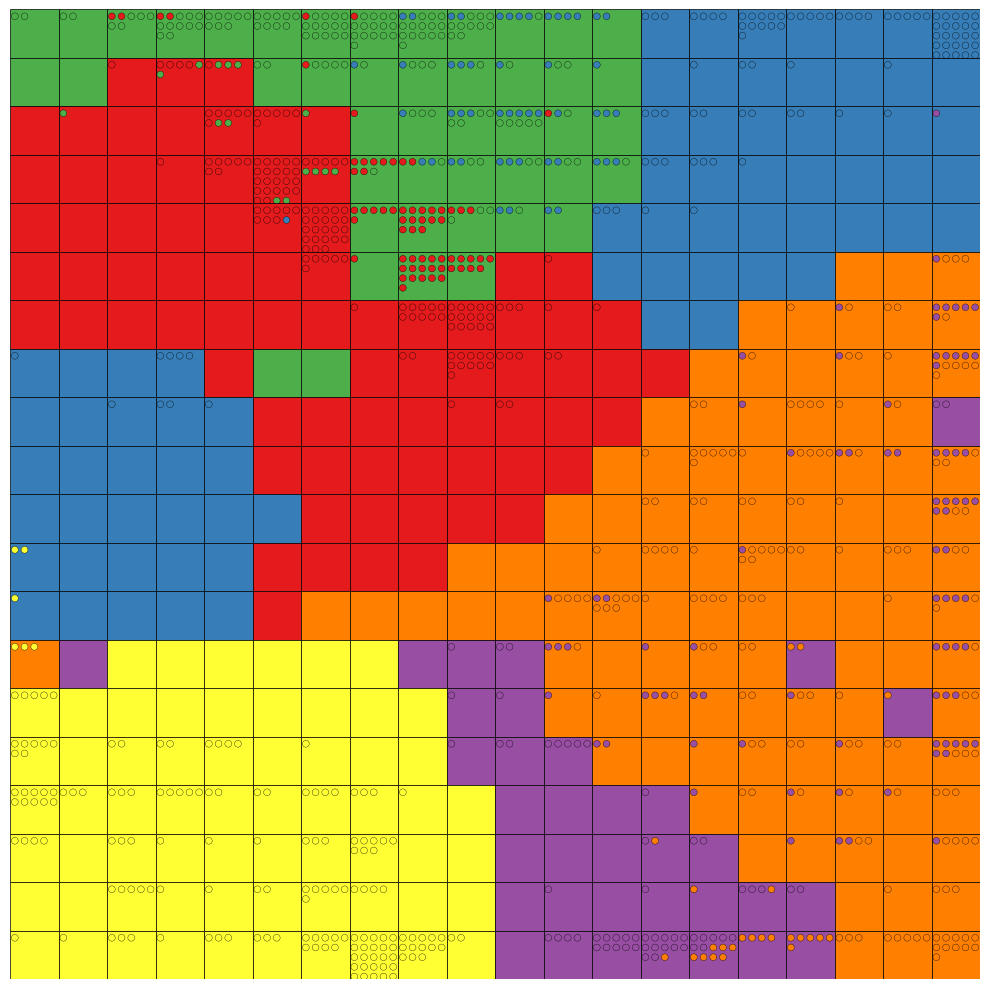

In [27]:
y = y - 1 # shiftujemy kategorie na 0
labeled = np.hstack((X, y.reshape(-1, 1)))
weightsnp = copy.deepcopy(network.weights)
for i in range(len(weightsnp)):
    for j in range(len(weightsnp[0])):
        weightsnp[i][j] = list(weightsnp[i][j])

weightsnp = np.array(weightsnp)
closest_data = get_closest_data(weightsnp, labeled[:1000])
closest_data2 = get_closest_data_neuron(weightsnp, labeled[:1000])
visualise_kohonen(closest_data, closest_data2)

np.float64(1.0)